# Credit Card Fraud
Unit 3 / Lesson 6 / Project 1

Using this [credit card fraud dataset](https://www.kaggle.com/mlg-ulb/creditcardfraud) develop an algorithm to predict fraud.
Prioritize correctly finding fraud rather than correctly labeling non-fraudulent transactions.

Due to the unbalanced nature of the data, our model will appear to perform very well with no optimization or data preprocessing.
Since only 0.172% of transactions are flagged as fraud, even the simplest model that flags all transactions as 'not fraud' will still have a 99.828% success rate.

Use [this resource](https://imbalanced-learn.readthedocs.io/en/stable/auto_examples/index.html) to adjust for class imbalances.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from imblearn import over_sampling as os
from imblearn import pipeline as pl
from imblearn.metrics import classification_report_imbalanced

# train test split
from sklearn.model_selection import train_test_split
# stand scaler
from sklearn.preprocessing import StandardScaler

# Area Under the Precision-Recall Curve 
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# precision-recall curve and f1
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score

# select k best
from sklearn.feature_selection import SelectKBest, f_classif

# models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# random seach
from sklearn.model_selection import RandomizedSearchCV

# confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

## Import data

In [2]:
# import data
PATH = ('assets\creditcard.csv')
raw_data = pd.read_csv(PATH, index_col=None)

df = pd.DataFrame(raw_data)

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Context
It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

### Content
The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

### Inspiration
Identify fraudulent credit card transactions.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

### Acknowledgements
The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection. More details on current and past projects on related topics are available on https://www.researchgate.net/project/Fraud-detection-5 and the page of the DefeatFraud project

Please cite the following works:

Andrea Dal Pozzolo, Olivier Caelen, Reid A. Johnson and Gianluca Bontempi. Calibrating Probability with Undersampling for Unbalanced Classification. In Symposium on Computational Intelligence and Data Mining (CIDM), IEEE, 2015

Dal Pozzolo, Andrea; Caelen, Olivier; Le Borgne, Yann-Ael; Waterschoot, Serge; Bontempi, Gianluca. Learned lessons in credit card fraud detection from a practitioner perspective, Expert systems with applications,41,10,4915-4928,2014, Pergamon

Dal Pozzolo, Andrea; Boracchi, Giacomo; Caelen, Olivier; Alippi, Cesare; Bontempi, Gianluca. Credit card fraud detection: a realistic modeling and a novel learning strategy, IEEE transactions on neural networks and learning systems,29,8,3784-3797,2018,IEEE

Dal Pozzolo, Andrea Adaptive Machine learning for credit card fraud detection ULB MLG PhD thesis (supervised by G. Bontempi)
Carcillo, Fabrizio; Dal Pozzolo, Andrea; Le Borgne, Yann-Aël; Caelen, Olivier; Mazzer, Yannis; Bontempi, Gianluca. Scarff: a scalable framework for streaming credit card fraud detection with Spark, Information fusion,41, 182-194,2018,Elsevier

Carcillo, Fabrizio; Le Borgne, Yann-Aël; Caelen, Olivier; Bontempi, Gianluca. Streaming active learning strategies for real-life credit card fraud detection: assessment and visualization, International Journal of Data Science and Analytics, 5,4,285-300,2018,Springer International Publishing

## EDA
Let's explore the data and get an idea of what we're working with.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

In [4]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,...,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


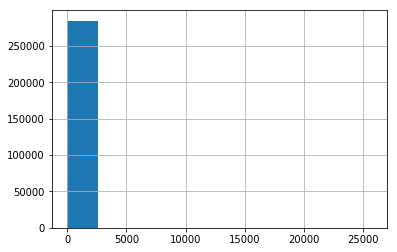

In [5]:
# view price data
df.Amount.hist();

Let's see if we can log transform the transaction amount data to create a distribution we can work with.

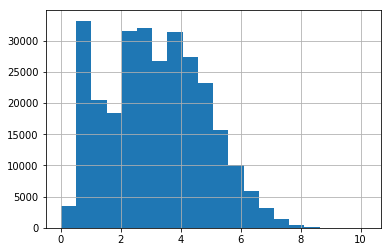

In [6]:
# log transform price data
df['log_Amount'] = np.log1p(df.Amount)

# view log(price) data
df.log_Amount.hist(bins=20);

That's much better.
Now let's compare the distribution of transaction amounts for fraudulent transactions and non-fraudulent transactions.

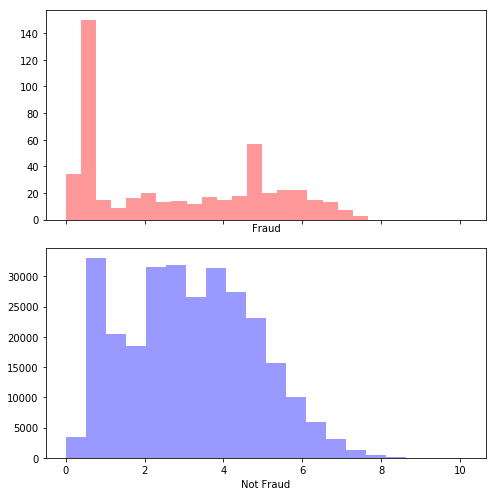

In [7]:
# view price data of fraudulent transactions
f, axes = plt.subplots(2, 1, figsize=(7, 7), sharex=True)

sns.distplot(df.log_Amount.loc[df['Class']==1],
             kde=False, bins=20, ax=axes[0], axlabel='Fraud', color='r')
sns.distplot(df.log_Amount.loc[df['Class']==0],
             kde=False, bins=20, ax=axes[1], axlabel='Not Fraud', color='b')

plt.tight_layout()
plt.show()

## Data Cleaning

Our data isn't missing any values and our data types all appear to be correct.
Since our data is clean, let's see if standardizing the data affects our model.

In [8]:
# define data and target
data = df.drop('Class', axis=1)
target = df['Class']

# define training and test set
X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.2, random_state=42, stratify=target)

# scale data
scaler = StandardScaler()
# fit transform X_train
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
# transform X_test
X_test_scaled = scaler.transform(X_test)

Now our data is standardized, squeaky clean, and ready to model.

## Model Selection
Let's try some exploratory models to get a baseline of how our data performs without much manipulation.
Since this is a classification problem, let's compare the out-of-the-box performance of the logistic regression, a random forest classifier, and a gradient boosting classifier.

### Logistic Regression

In [9]:
LR = LogisticRegression()

# make pipeline
pipeline = pl.make_pipeline(os.SMOTE(random_state=42), LR)
# Train the classifier with balancing
pipeline.fit(X_train, y_train)

# Test the classifier and get the prediction
y_pred_bal = pipeline.predict(X_test)

# Show the classification report
print(classification_report_imbalanced(y_test, y_pred_bal))

C:\Users\Aaron\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.98      0.91      0.99      0.95      0.90     56864
          1       0.09      0.91      0.98      0.16      0.95      0.89        98

avg / total       1.00      0.98      0.91      0.99      0.95      0.90     56962



AUC: 0.977


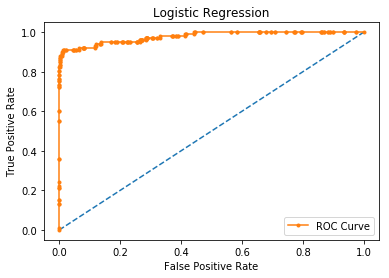

In [10]:
# predict probabilities
probs = pipeline.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]

# calculate AUC
auc_score = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc_score)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)

# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.', label='ROC Curve')
plt.title('Logistic Regression')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

f1=0.161 auc=0.704 ap=0.706


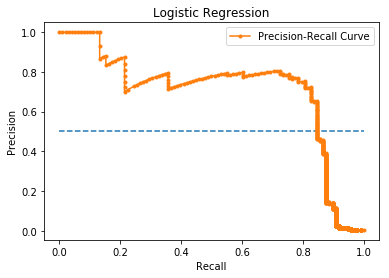

In [11]:
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, probs)

# calculate F1 score
f1 = f1_score(y_test, y_pred_bal)

# calculate precision-recall AUC
auc_score = auc(recall, precision)

# calculate average precision score
ap = average_precision_score(y_test, probs)
print('f1=%.3f auc=%.3f ap=%.3f' % (f1, auc_score, ap))

# plot no skill
plt.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the precision-recall curve for the model
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.title('Logistic Regression')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

### Random Forest Classifier

In [12]:
RFC = RandomForestClassifier(n_estimators=10)

# make pipeline
pipeline = pl.make_pipeline(os.SMOTE(random_state=42), RFC)
# Train the classifier with balancing
pipeline.fit(X_train, y_train)

# Test the classifier and get the prediction
y_pred_bal = pipeline.predict(X_test)

# Show the classification report
print(classification_report_imbalanced(y_test, y_pred_bal))

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      1.00      0.84      1.00      0.91      0.85     56864
          1       0.84      0.84      1.00      0.84      0.91      0.82        98

avg / total       1.00      1.00      0.84      1.00      0.91      0.85     56962



AUC: 0.948


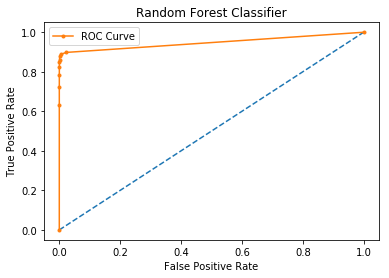

In [13]:
# predict probabilities
probs = pipeline.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]

# calculate AUC
auc_score = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc_score)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)

# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.', label='ROC Curve')
plt.title('Random Forest Classifier')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

f1=0.837 auc=0.852 ap=0.831


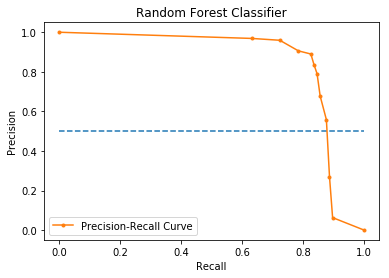

In [14]:
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, probs)

# calculate F1 score
f1 = f1_score(y_test, y_pred_bal)

# calculate precision-recall AUC
auc_score = auc(recall, precision)

# calculate average precision score
ap = average_precision_score(y_test, probs)
print('f1=%.3f auc=%.3f ap=%.3f' % (f1, auc_score, ap))

# plot no skill
plt.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the precision-recall curve for the model
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.title('Random Forest Classifier')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

### Gradient Boosting Classifier

In [15]:
CLF = GradientBoostingClassifier()

# make pipeline
pipeline = pl.make_pipeline(os.SMOTE(random_state=42), CLF)
# Train the classifier with balancing
pipeline.fit(X_train, y_train)

# Test the classifier and get the prediction
y_pred_bal = pipeline.predict(X_test)

# Show the classification report
print(classification_report_imbalanced(y_test, y_pred_bal))

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.99      0.90      1.00      0.94      0.90     56864
          1       0.19      0.90      0.99      0.31      0.94      0.88        98

avg / total       1.00      0.99      0.90      1.00      0.94      0.90     56962



AUC: 0.978


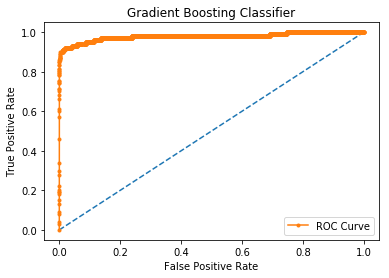

In [16]:
# predict probabilities
probs = pipeline.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]

# calculate AUC
auc_score = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc_score)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)

# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.', label='ROC Curve')
plt.title('Gradient Boosting Classifier')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

f1=0.313 auc=0.786 ap=0.779


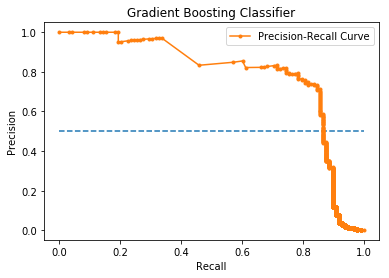

In [17]:
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, probs)

# calculate F1 score
f1 = f1_score(y_test, y_pred_bal)

# calculate precision-recall AUC
auc_score = auc(recall, precision)

# calculate average precision score
ap = average_precision_score(y_test, probs)
print('f1=%.3f auc=%.3f ap=%.3f' % (f1, auc_score, ap))

# plot no skill
plt.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the precision-recall curve for the model
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.title('Gradient Boosting Classifier')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

## Scaled models
### Scaled Logistic Regression

In [18]:
# import logistic regression from sklearn
LR_scaled = LogisticRegression()

# make pipeline
pipeline = pl.make_pipeline(os.SMOTE(random_state=42), LR_scaled)
# Train the classifier with balancing
pipeline.fit(X_train_scaled, y_train)

# Test the classifier and get the prediction
y_pred_bal = pipeline.predict(X_test_scaled)

# Show the classification report
print(classification_report_imbalanced(y_test, y_pred_bal))

C:\Users\Aaron\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.97      0.92      0.99      0.95      0.90     56864
          1       0.06      0.92      0.97      0.11      0.95      0.89        98

avg / total       1.00      0.97      0.92      0.99      0.95      0.90     56962



AUC: 0.971


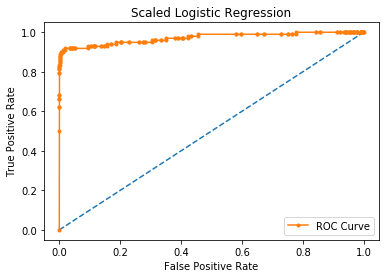

In [19]:
# predict probabilities
probs = pipeline.predict_proba(X_test_scaled)
# keep probabilities for the positive outcome only
probs = probs[:, 1]

# calculate AUC
auc_score = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc_score)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)

# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.', label='ROC Curve')
plt.title('Scaled Logistic Regression')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

f1=0.110 auc=0.768 ap=0.723


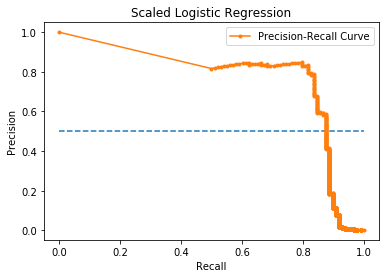

In [20]:
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, probs)

# calculate F1 score
f1 = f1_score(y_test, y_pred_bal)

# calculate precision-recall AUC
auc_score = auc(recall, precision)

# calculate average precision score
ap = average_precision_score(y_test, probs)
print('f1=%.3f auc=%.3f ap=%.3f' % (f1, auc_score, ap))

# plot no skill
plt.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the precision-recall curve for the model
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.title('Scaled Logistic Regression')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

### Scaled Random Forest Classifier

In [21]:
# import random forest classifier from sklearn
RFC_scaled = RandomForestClassifier(n_estimators=10)

# make pipeline
pipeline = pl.make_pipeline(os.SMOTE(random_state=42), RFC_scaled)
# Train the classifier with balancing
pipeline.fit(X_train_scaled, y_train)

# Test the classifier and get the prediction
y_pred_bal = pipeline.predict(X_test_scaled)

# Show the classification report
print(classification_report_imbalanced(y_test, y_pred_bal))

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      1.00      0.85      1.00      0.92      0.86     56864
          1       0.82      0.85      1.00      0.83      0.92      0.83        98

avg / total       1.00      1.00      0.85      1.00      0.92      0.86     56962



AUC: 0.958


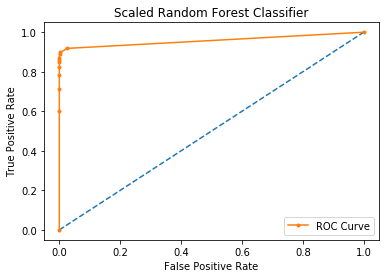

In [22]:
# predict probabilities
probs = pipeline.predict_proba(X_test_scaled)
# keep probabilities for the positive outcome only
probs = probs[:, 1]

# calculate AUC
auc_score = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc_score)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)

# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.', label='ROC Curve')
plt.title('Scaled Random Forest Classifier')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

f1=0.834 auc=0.867 ap=0.850


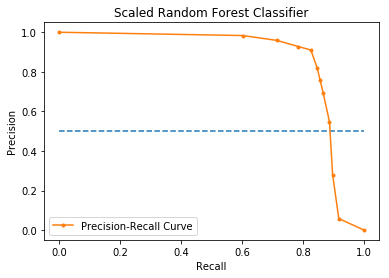

In [23]:
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, probs)

# calculate F1 score
f1 = f1_score(y_test, y_pred_bal)

# calculate precision-recall AUC
auc_score = auc(recall, precision)

# calculate average precision score
ap = average_precision_score(y_test, probs)
print('f1=%.3f auc=%.3f ap=%.3f' % (f1, auc_score, ap))

# plot no skill
plt.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the precision-recall curve for the model
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.title('Scaled Random Forest Classifier')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

### Scaled Gradient Boosting Classifier

In [24]:
# import gradient boosting classifier from sklearn
CLF_scaled = GradientBoostingClassifier()

# make pipeline
pipeline = pl.make_pipeline(os.SMOTE(random_state=42), CLF_scaled)
# Train the classifier with balancing
pipeline.fit(X_train_scaled, y_train)

# Test the classifier and get the prediction
y_pred_bal = pipeline.predict(X_test_scaled)

# Show the classification report
print(classification_report_imbalanced(y_test, y_pred_bal))

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.99      0.91      0.99      0.95      0.90     56864
          1       0.11      0.91      0.99      0.19      0.95      0.89        98

avg / total       1.00      0.99      0.91      0.99      0.95      0.90     56962



AUC: 0.983


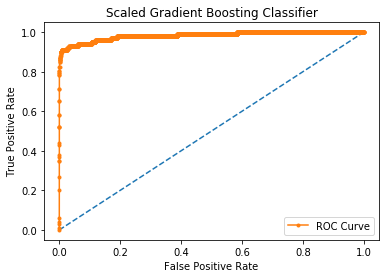

In [25]:
# predict probabilities
probs = pipeline.predict_proba(X_test_scaled)
# keep probabilities for the positive outcome only
probs = probs[:, 1]

# calculate AUC
auc_score = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc_score)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)

# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.', label='ROC Curve')
plt.title('Scaled Gradient Boosting Classifier')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

f1=0.189 auc=0.773 ap=0.772


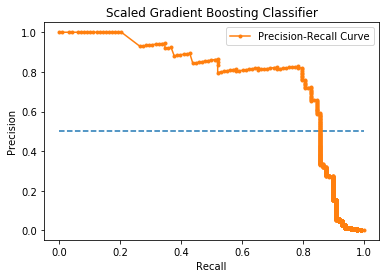

In [26]:
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, probs)

# calculate F1 score
f1 = f1_score(y_test, y_pred_bal)

# calculate precision-recall AUC
auc_score = auc(recall, precision)

# calculate average precision score
ap = average_precision_score(y_test, probs)
print('f1=%.3f auc=%.3f ap=%.3f' % (f1, auc_score, ap))

# plot no skill
plt.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the precision-recall curve for the model
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.title('Scaled Gradient Boosting Classifier')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

It looks like out of all of our models (logistic regression, random forest classifier, and gradient boosting classifier), the unscaled Random Forest Classifer performed the best.
The gradient boosting classifer did have the highest AUC score of the all the models, but a far too low F1 score.
The unscaled Random Forest Classifier had a similarly high AUC score and the highest F1 score of all the models. 

Let's explore our features and make sure these results aren't the product of overfitting or some correlation.

## Feature Selection

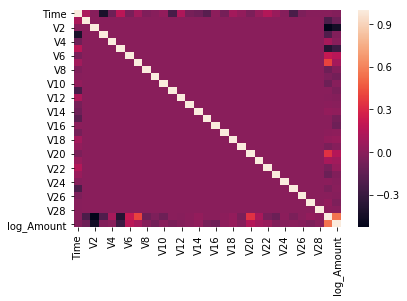

In [27]:
# plot a heatmap
sns.heatmap(data.corr());

It looks like none of our features are correlated.
This means our high model accuracy isn't due to correlated features.

Still, let's see if we can reduce our features and increase our models performance.

### Select K Best
Our model has 30 features, let's see if we can reduce that by a third.

In [28]:
display(data.shape)
classifier = SelectKBest(f_classif, k=20).fit(data, target)

(284807, 31)

In [29]:
# Create new dataframe with only desired columns, or overwrite existing
feature_names = list(data.columns.values)

# Get columns to keep
mask = classifier.get_support() #list of booleans
new_features = data.columns[mask]

#        
data_new = data[new_features]
display(data_new.shape)
data_new.head()

(284807, 20)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V14,V16,V17,V18,V19,V20,V21,V27
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.311169,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.133558
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,-0.143772,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.008983
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,-0.165946,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,-0.055353
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,-0.287924,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.062723
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,-1.119670,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.219422


Now we have our top 20 features.
Let's make another check for correlation before we procede to modeling.

### Check for correlation

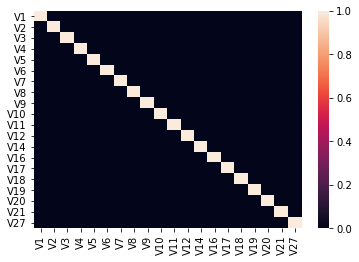

In [30]:
# plot a heatmap
sns.heatmap(data_new.corr());

Looks like our features exhibit no correlation.

In [31]:
# Create correlation matrix
corr_matrix = data_new.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=4).astype(np.bool))

# Find index of feature columns with correlation greater than 0.90
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

display(data_new.shape)

# Drop correlated features 
for i in to_drop:
    data_new = data_new.drop(i, axis=1)

data_new.shape

(284807, 20)

(284807, 20)

In [32]:
# define training and test set with new features
X_train, X_test, y_train, y_test = train_test_split(
    data_new, target, test_size=0.2, random_state=42, stratify=target)

Now that we have our new set of features, let's optimize our model.

## Parameter Optimization
Now that we've selected our model, we can use grid search or random search to optimize our models parameters.
But first, let's get a baseline of performance to compare our optimized model to.

### Sample dataset
Sample 50% of training data for model optimization.

In [33]:
# sample training data
X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [40]:
# define our parameter ranges
n_estimators=[int(x) for x in np.linspace(start = 10, stop = 100, num = 3)]
criterion=['gini', 'entropy']
max_depth=[int(x) for x in np.linspace(start = 3, stop = 10, num = 3)]
max_depth.append(None)
min_samples_split=[int(x) for x in np.linspace(start = 2, stop = 5, num = 3)]
min_samples_leaf=[int(x) for x in np.linspace(start = 1, stop = 4, num = 3)]
max_features=['auto', 'sqrt']
# Create the random grid
param_grid = {'n_estimators':n_estimators,
              #'criterion':criterion,
              'max_depth':max_depth,
              'min_samples_split':min_samples_split,
              'min_samples_leaf':min_samples_leaf,
              'max_features':max_features
             }

print(param_grid)

# Initialize and fit the model.
model = RandomForestClassifier()
# parameter optimization
model = RandomizedSearchCV(model, param_grid, cv=3)
# make pipeline
pipeline = pl.make_pipeline(os.SMOTE(random_state=42), model)
# Train the classifier with balancing
pipeline.fit(X_train_sample, y_train_sample)

# get the best parameters
best_params = model.best_params_
print(best_params)

{'n_estimators': [10, 55, 100], 'max_depth': [3, 6, 10, None], 'min_samples_split': [2, 3, 5], 'min_samples_leaf': [1, 2, 4], 'max_features': ['auto', 'sqrt']}
{'n_estimators': 55, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}


In [41]:
# refit model with best parameters
model_best = RandomForestClassifier(**best_params)
# make pipeline
pipeline_best = pl.make_pipeline(os.SMOTE(random_state=42), model_best)
# Train the classifier with balancing
pipeline_best.fit(X_train, y_train)
# Test the classifierand get the prediction
y_pred_bal = pipeline_best.predict(X_test)

# create a dictionary to hold our metrics
metrics_dict = {}

In [47]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Recall metric in the train dataset: 100.0%


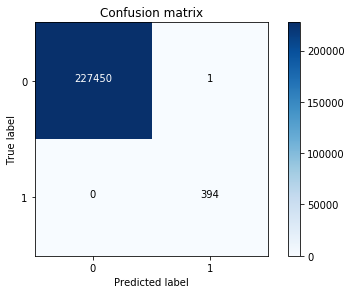

In [48]:
#
y_pred_train = pipeline_best.predict(X_train)
cnf_matrix_tra = confusion_matrix(y_train, y_pred_train)

#
metrics_dict['Train recall metric'] = 100*cnf_matrix_tra[1,1]/(cnf_matrix_tra[1,0]+cnf_matrix_tra[1,1])
print("Recall metric in the train dataset: {}%".format(metrics_dict['Train recall metric'])
     )

#
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix_tra , classes=class_names, title='Confusion matrix')
plt.show()

Recall metric in the testing dataset: 81.63265306122449%


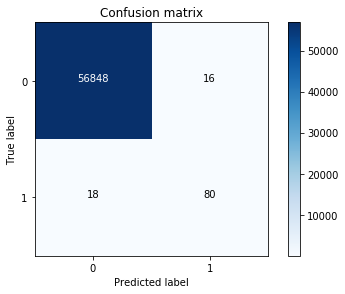

In [49]:
cnf_matrix = confusion_matrix(y_test, y_pred_bal)

metrics_dict['Test recall metric']=100*cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])
print("Recall metric in the testing dataset: {}%".format(metrics_dict['Test recall metric'])
     )
#print("Precision metric in the testing dataset: {}%".format(
#    100*cnf_matrix[0,0]/(cnf_matrix[0,0]+cnf_matrix[1,0]))
#     )
# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix , classes=class_names, title='Confusion matrix')
plt.show()

ROC-AUC: 0.959


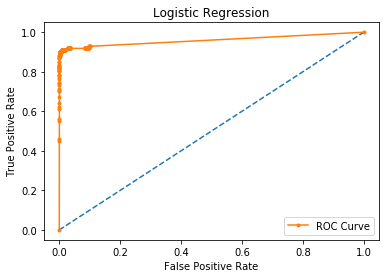

In [50]:
# predict probabilities
probs = pipeline.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]

# calculate AUC
auc_score = roc_auc_score(y_test, probs)
metrics_dict['ROC-AUC'] = auc_score
print('ROC-AUC: %.3f' % metrics_dict['ROC-AUC'])
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)

# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.', label='ROC Curve')
plt.title('Logistic Regression')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

f1=0.825 auc=0.844 ap=0.844


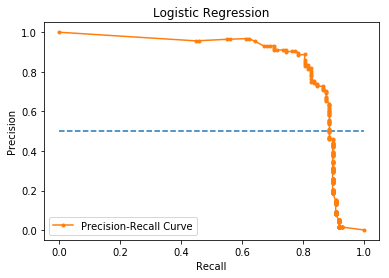

In [51]:
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, probs)

# calculate F1 score
metrics_dict['F1 score'] = f1_score(y_test, y_pred_bal)

# calculate precision-recall AUC
metrics_dict['Precision-Recall AUC'] = auc(recall, precision)

# calculate average precision score
metrics_dict['Average Precision'] = average_precision_score(y_test, probs)
print('f1=%.3f auc=%.3f ap=%.3f' % (metrics_dict['F1 score'],
                                    metrics_dict['Precision-Recall AUC'],
                                    metrics_dict['Precision-Recall AUC']))

# plot no skill
plt.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the precision-recall curve for the model
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.title('Logistic Regression')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [52]:
# view metrics
for i in metrics_dict.items():
    print(i)

('Train recall metric', 100.0)
('Test recall metric', 81.63265306122449)
('ROC-AUC', 0.9593205916300117)
('F1 score', 0.8247422680412372)
('Precision-Recall AUC', 0.8438859720228018)
('Average Precision', 0.8331244712525048)


Our metrics looks consistent across the testing and training sets.
We were able to optimize our model to have an F1-score of ~82%, and an average Precision score of ~83%.